In [123]:
import keras
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from constants import SPECIES
import cv2
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dropout, Conv2D
from keras.models import Model
from keras.utils import np_utils


In [85]:
# import the images from the folder
test = []
train = []
for species in SPECIES:
    for file in os.listdir('img/Test/' + species):
        test.append([file, species])
    for file in os.listdir('img/Train/' + species):
        train.append([file, species])

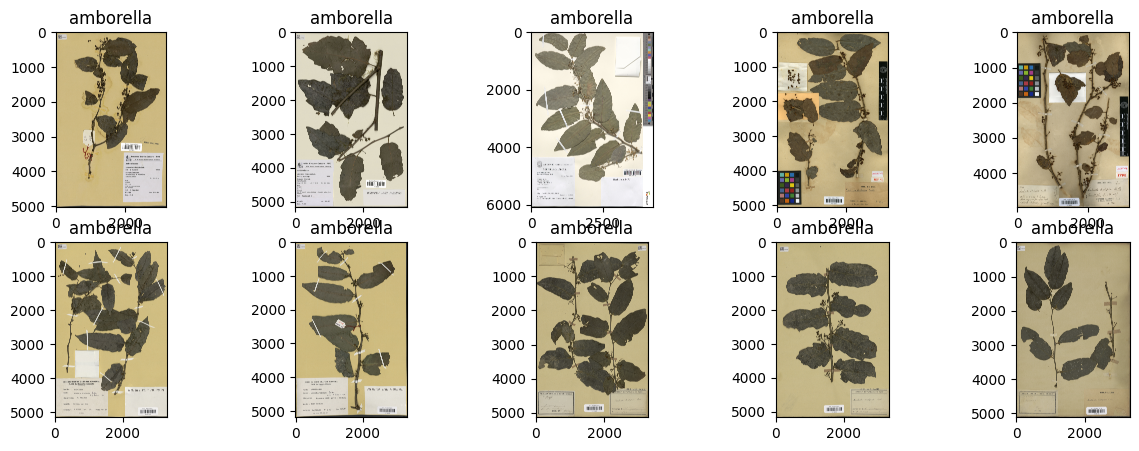

In [86]:
# plot the first 5 images of the training set and test set
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    img = plt.imread('img/Train/' + train[i][1] + '/' + train[i][0])
    ax[0, i].imshow(img)
    ax[0, i].set_title(train[i][1])
    img = plt.imread('img/Test/' + test[i][1] + '/' + test[i][0])
    ax[1, i].imshow(img)
    ax[1, i].set_title(test[i][1])
plt.show()


In [87]:
# remove the background of the images
def remove_background(img):
    colored_image = cv2.imread(img)
    grey_image = cv2.cvtColor(colored_image, cv2.COLOR_RGB2GRAY)
    for _ in range(3):
        grey_image = cv2.GaussianBlur(grey_image, (51, 51), 0)
    _, thresh = cv2.threshold(grey_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Apply mask to colored_image
    colored_image = cv2.bitwise_or(colored_image, colored_image, mask=cv2.bitwise_not(thresh))
    return colored_image

In [76]:
# for each image in the training set, remove the background
for i in range(len(train)):
    img = remove_background('img/Train/' + train[i][1] + '/' + train[i][0])
    cv2.imwrite('img/Train background/' + train[i][1] + '/' + train[i][0], img)

# for each image in the test set, remove the background
for i in range(len(test)):
    img = remove_background('img/Test/' + test[i][1] + '/' + test[i][0])
    cv2.imwrite('img/Test background/' + test[i][1] + '/' + test[i][0], img)


In [88]:
# for each image, randomly create 6 224x224 crops
def crop(img, n, size):
    crops = []
    for i in range(n):
        x = np.random.randint(0, img.shape[0] - size)
        y = np.random.randint(0, img.shape[1] - size)
        crops.append(img[x:x + size, y:y + size, :])
    return crops

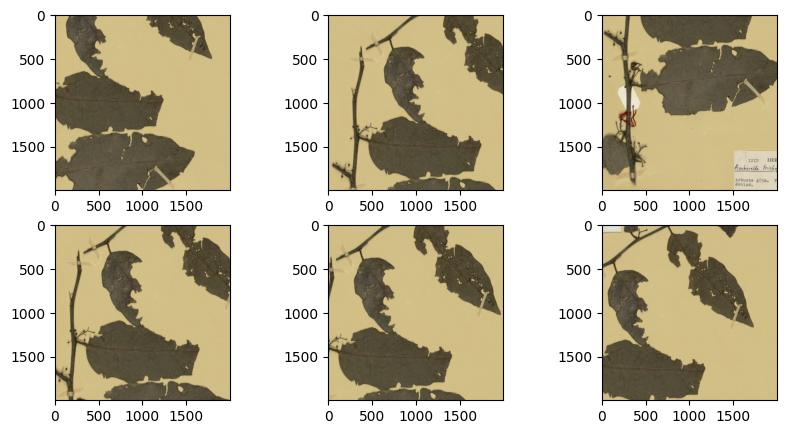

In [98]:
# test the crop function
img = plt.imread('img/Train/' + train[5][1] + '/' + train[5][0])   
crops = crop(img, 6, 2000)
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
for i in range(3):
    ax[0, i].imshow(crops[i])
    ax[1, i].imshow(crops[i + 3])
plt.show()


In [128]:
# create the training set
X_train = []
y_train = []
for i in range(len(train)):
    img_bg = plt.imread('img/Train background/' + train[i][1] + '/' + train[i][0])
    img = plt.imread('img/Train/' + train[i][1] + '/' + train[i][0])
    crops_bg = crop(img_bg, 6, 2000)
    crops = crop(img, 6, 2000)
    for j in range(6):
        X_train.append(crops_bg[j])
        y_train.append(train[i][1])
        X_train.append(crops[j])
        y_train.append(train[i][1])


In [129]:
# create the test set
X_test = []
y_test = []
for i in range(len(test)):
    img = plt.imread('img/Test/' + test[i][1] + '/' + test[i][0])
    X_test.append(img)
    y_test.append(test[i][1])

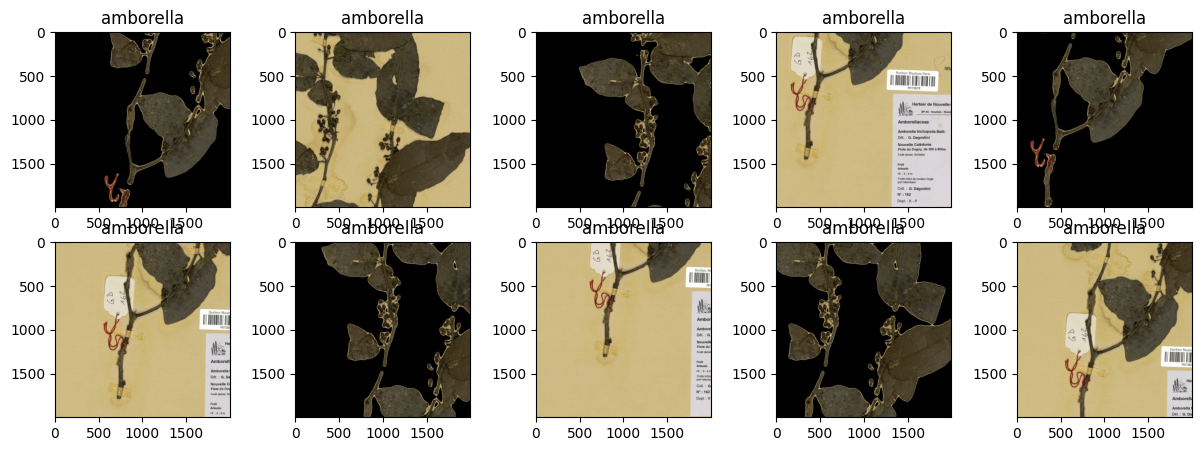

In [130]:
# display the first 10 images of the training set
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    ax[0, i].imshow(X_train[i])
    ax[0, i].set_title(y_train[i])
    ax[1, i].imshow(X_train[i + 5])
    ax[1, i].set_title(y_train[i + 5])
plt.show()


In [131]:
# shape of the training set
print(len(X_train))

2640


In [132]:
# resize the images to 224x224
X_train = [cv2.resize(img, (224, 224)) for img in X_train]

In [133]:
# shuffle the training set
X_train, y_train = np.array(X_train), np.array(y_train)
idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[idx], y_train[idx]

In [134]:
# take 10% of the training set as validation set
X_val = X_train[:int(len(X_train) * 0.1)]
y_val = y_train[:int(len(X_train) * 0.1)]
X_train = X_train[int(len(X_train) * 0.1):]
y_train = y_train[int(len(X_train) * 0.1):]

In [137]:
num_classes = len(SPECIES)

# one-hot encode the labels
SPECIES_TO_NUM = {species: i for i, species in enumerate(SPECIES)}

In [139]:
y_train = np_utils.to_categorical([SPECIES_TO_NUM[species] for species in y_train], num_classes)
y_val = np_utils.to_categorical([SPECIES_TO_NUM[species] for species in y_val], num_classes)